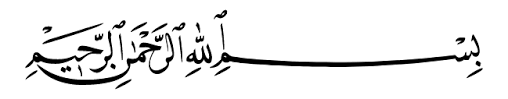

# Première partie: la segmentation des panneaux photovoltaïques à partir d'images satellites et aériennes Multi-Résolution
---------------------------------------------------------------------------------------------------------------------------

**- EL MOUKHTAR Abdelmalek                                                        
      - E-mail1: abdelmalekelmoukhtar@gmail.com                  
      - E-mail2: a.elmoukhtar99@gmail.com               
      - E-mail3: abdelmalek.elmoukhtar@edu.uca.ma**

# Import My Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#drive="/content/gdrive/My Drive/MSDAD/S4_PFE Master/PV01"
#drive="/content/gdrive/My Drive/MSDAD/S4_PFE Master/PV03"
#drive="/content/gdrive/My Drive/MSDAD/S4_PFE Master/PV08"
drive="/content/gdrive/My Drive/MSDAD/S4_PFE Master/PVs"

# Import packages

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [ ]:
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use("ggplot")
%matplotlib inline

import cv2
from itertools import chain
from tqdm import tqdm_notebook,tnrange
from glob import glob
from skimage.io import imread, imshow,concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load dataset

In [ ]:
DataPath = drive

In [ ]:
dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'label'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_label', ''))

In [ ]:
print(masks[:10])
print(images[:10])

['PV01_325139_1204224_label.bmp', 'PV01_325139_1204227_label.bmp', 'PV01_325141_1204229_label.bmp', 'PV01_325139_1204235_label.bmp', 'PV01_325139_1204232_label.bmp', 'PV01_325141_1204224_label.bmp', 'PV01_325141_1204227_label.bmp', 'PV01_325139_1204229_label.bmp', 'PV01_325141_1204240_label.bmp', 'PV01_325141_1204246_label.bmp']
['PV01_325139_1204224.bmp', 'PV01_325139_1204227.bmp', 'PV01_325141_1204229.bmp', 'PV01_325139_1204235.bmp', 'PV01_325139_1204232.bmp', 'PV01_325141_1204224.bmp', 'PV01_325141_1204227.bmp', 'PV01_325139_1204229.bmp', 'PV01_325141_1204240.bmp', 'PV01_325141_1204246.bmp']


In [ ]:
len(dirs), len(images), len(masks)

(645, 645, 645)

In [ ]:
imagePath_df = pd.DataFrame({'directory':dirs, 'images':images,'masks':masks})

In [ ]:
imagePath_df.head(9)

,directory,images,masks
0,PV01_Rooftop_SteelTile,PV01_325139_1204224.bmp,PV01_325139_1204224_label.bmp
1,PV01_Rooftop_SteelTile,PV01_325139_1204227.bmp,PV01_325139_1204227_label.bmp
2,PV01_Rooftop_SteelTile,PV01_325141_1204229.bmp,PV01_325141_1204229_label.bmp
3,PV01_Rooftop_SteelTile,PV01_325139_1204235.bmp,PV01_325139_1204235_label.bmp
4,PV01_Rooftop_SteelTile,PV01_325139_1204232.bmp,PV01_325139_1204232_label.bmp
5,PV01_Rooftop_SteelTile,PV01_325141_1204224.bmp,PV01_325141_1204224_label.bmp
6,PV01_Rooftop_SteelTile,PV01_325141_1204227.bmp,PV01_325141_1204227_label.bmp
7,PV01_Rooftop_SteelTile,PV01_325139_1204229.bmp,PV01_325139_1204229_label.bmp
8,PV01_Rooftop_SteelTile,PV01_325141_1204240.bmp,PV01_325141_1204240_label.bmp


#Images shape

In [ ]:
def print_imShape():
    idx = random.randint(0,len(dirs))
    
    imagePath = os.path.join(DataPath,imagePath_df['directory'].iloc[idx],  imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath,imagePath_df['directory'].iloc[idx],  imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    print(image.shape)
    print(mask.shape)

In [ ]:
for i in range(5):
    print_imShape()

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


# Plot Images

In [ ]:
def plot_images():
    
    idx = random.randint(0,len(imagePath_df))
    
    imagePath = os.path.join(DataPath,imagePath_df['directory'].iloc[idx],  imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath,imagePath_df['directory'].iloc[idx],  imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[13,15])
    
    axs[0].imshow(image)
    axs[0].set_title("imge")
    
    plt.grid(False)
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    plt.grid(False)
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('imge with mask')
    
    plt.grid(False)
    plt.show()


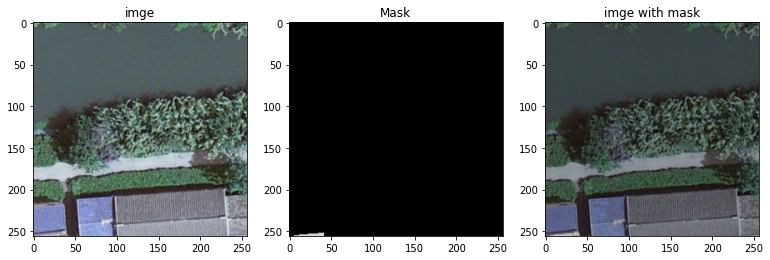

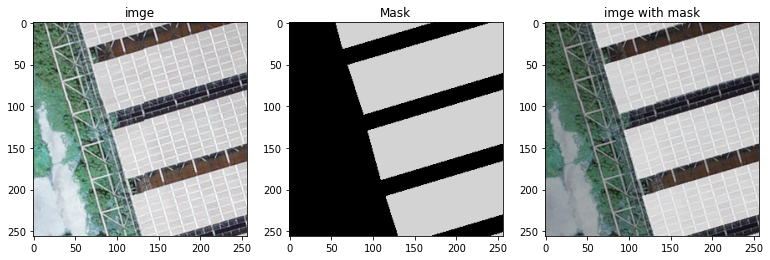

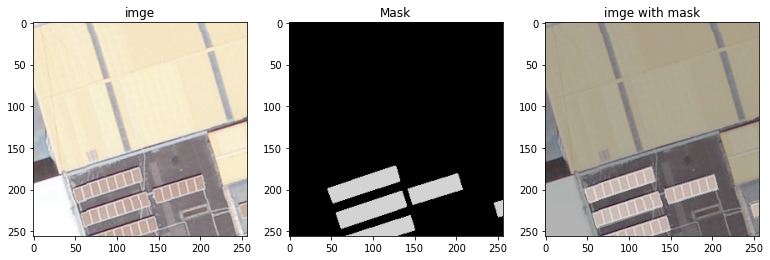

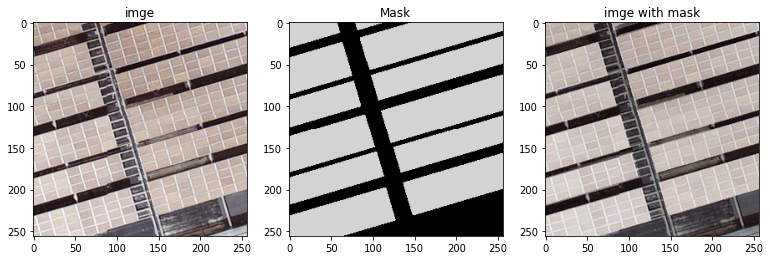

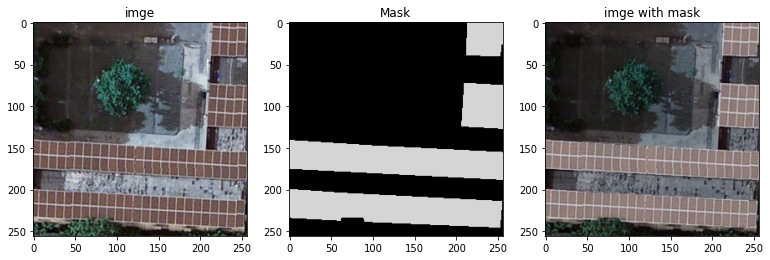

In [ ]:
for i in range(5):
    plot_images()

# **Config**

In [ ]:
imagePath_df['image-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['masks'] 

In [ ]:
train, test = train_test_split(imagePath_df,test_size=0.2, random_state=21)
#train,val = train_test_split(trainval, test_size=0.2, random_state=21)

# **Play with Epochs , Batch_size later**

In [ ]:
35*32 == len(images)

False

In [ ]:
EPOCHS =35#Exemple 35
BATCH_SIZE = 32
ImgHeight = 256
ImgWidth = 256
Channels = 3

# **Data Generator**

In [ ]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [ ]:
#image generator

imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='rgb')
# validation data generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='grayscale')     

Found 516 validated image filenames.
Found 516 validated image filenames.


# **Validation**

In [ ]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)

#train generator
vimage_generator = imagegen.flow_from_dataframe(dataframe=test,
                                             x_col = "image-path",
                                             batch_size = BATCH_SIZE,
                                             seed=42,
                                             class_mode=None,
                                             target_size = (ImgHeight,ImgWidth),
                                             color_mode='rgb')
# validation data generator
vmask_generator = maskgen.flow_from_dataframe(dataframe=test,
                                             x_col = "mask-path",
                                             batch_size = BATCH_SIZE,
                                             seed=42,
                                             class_mode=None,
                                             target_size = (ImgHeight,ImgWidth),
                                             color_mode='grayscale')

Found 129 validated image filenames.
Found 129 validated image filenames.


In [ ]:
def data_iterator(image_gen,mask_gen):
    for img, mask in zip(image_gen,mask_gen):
        yield img, mask

In [ ]:
train_gen = data_iterator(timage_generator, tmask_generator)
val_gen = data_iterator(vimage_generator,vmask_generator)

# **UNet Architecture**

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def UNET(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
def iou(ytrue, ypred):
    smoothing_factor=0.1
    #y_true_f=K.flatten(y_true)
    #y_pred_f=K.flatten(y_pred)
    intersection = K.sum(ytrue*ypred)
    combined_area = K.sum(ytrue+ypred)
    union_area = combined_area - intersection
    iou = (intersection+smoothing_factor)/(union_area+smoothing_factor)
    return iou

def jac_distance(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    return -iou(y_true, y_pred)

# Dice Sorenson
def dice_coef(ytrue, ypred):
    smoothing_factor=0.1
    ytrue_f = K.flatten(ytrue)
    ypred_f = K.flatten(ypred)
    intersection = K.sum(ytrue*ypred)
    ytrue_area = K.sum(ytrue)
    ypred_area = K.sum(ypred)
    combined_area = ytrue_area + ypred_area
    dice = 2*((intersection+smoothing_factor)/(combined_area+smoothing_factor))
    return dice

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
input_img = Input((ImgHeight,ImgWidth,3), name='img')
model = UNET(input_img, n_filters=16, dropout=0.2, batchnorm=True)
# model.compile(optimizer=Adam(), loss = "binary_crossentropy", metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.MeanIoU(num_classes=2)])
""" training """
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", iou, dice_coef,tf.keras.metrics.Precision()])

# tf.keras.metrics.Precision()
# tf.keras.metrics.MeanIoU(num_classes, name=None, dtype=None)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [ ]:
callbacks =[
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('model-brain-mri.h5', verbose=1, save_best_only=True, save_weights_only=True)]

In [ ]:
STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE

In [ ]:
results = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=val_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/35
17/16 [===============================] - ETA: -12s - loss: 0.5841 - accuracy: 0.4890 - iou: 0.2569 - dice_coef: 0.4055 - precision: 0.5279
Epoch 1: val_loss improved from inf to 3.55657, saving model to model-brain-mri.h5
16/16 [==============================] - 307s 19s/step - loss: 0.5841 - accuracy: 0.4890 - iou: 0.2569 - dice_coef: 0.4055 - precision: 0.5279 - val_loss: 3.5566 - val_accuracy: 0.0613 - val_iou: 0.2808 - val_dice_coef: 0.4379 - val_precision: 0.3401 - lr: 0.0010
Epoch 2/35
17/16 [===============================] - ETA: -13s - loss: 0.4318 - accuracy: 0.6253 - iou: 0.3619 - dice_coef: 0.5305 - precision: 0.7872
Epoch 2: val_loss improved from 3.55657 to 2.08472, saving model to model-brain-mri.h5
16/16 [==============================] - 272s 17s/step - loss: 0.4318 - accuracy: 0.6253 - iou: 0.3619 - dice_coef: 0.5305 - precision: 0.7872 - val_loss: 2.0847 - val_accuracy: 0.6536 - val_iou: 0.0124 - val_dice_coef: 0.0244 - val_precision: 0.0232 - lr: 0.0010


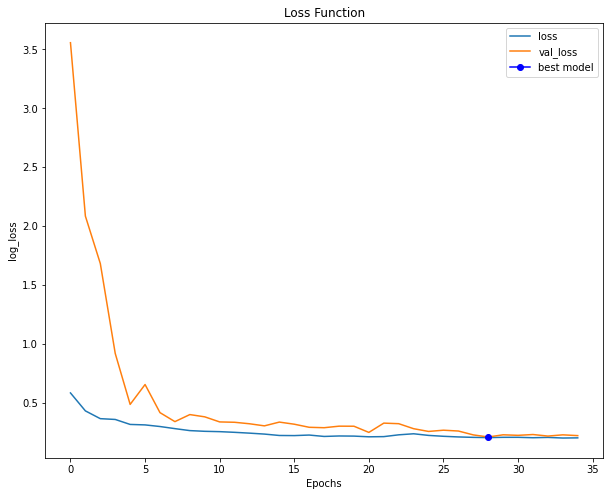

In [ ]:
plt.figure(figsize=[10,8])
plt.title("Loss Function")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")

plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="o", color="b", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()

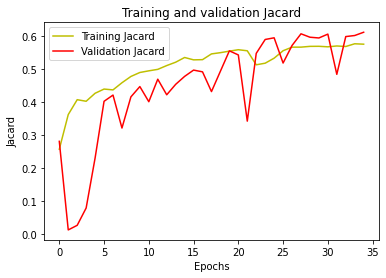

In [ ]:
plt.title("Loss Function")

plt.title('Training and validation Jacard')
plt.plot(results.history["iou"], 'y', label='Training Jacard')
plt.plot(results.history['val_iou'], 'r', label='Validation Jacard')

plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

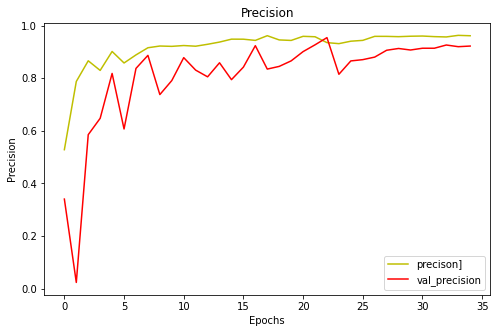

In [ ]:
plt.figure(figsize=[8,5])
plt.title("Precision")
plt.plot(results.history["precision"],'y', label = "precison]")
plt.plot(results.history["val_precision"], 'r', label='val_precision')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
# plt.grid(False)
plt.show()

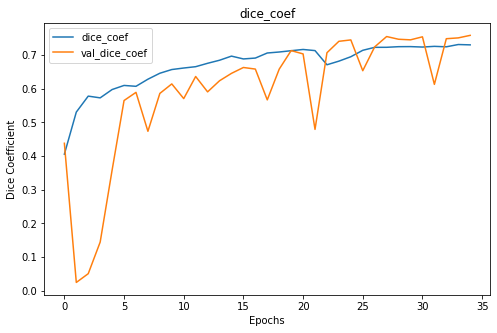

In [ ]:
plt.figure(figsize=[8,5])
plt.title("dice_coef")
plt.plot(results.history["dice_coef"], label = "dice_coef")
plt.plot(results.history["val_dice_coef"], label = "val_dice_coef")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
# plt.grid(False)
plt.show()

# **Prediction**

In [ ]:
model.load_weights('model-brain-mri.h5')
# model =models.load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
eval_results = model.evaluate(val_gen, steps=STEP_SIZE_VALID, verbose=1)

4/4 [==============================] - 14s 3s/step - loss: 0.2283 - accuracy: 0.6483 - iou: 0.6050 - dice_coef: 0.7537 - precision: 0.9066    


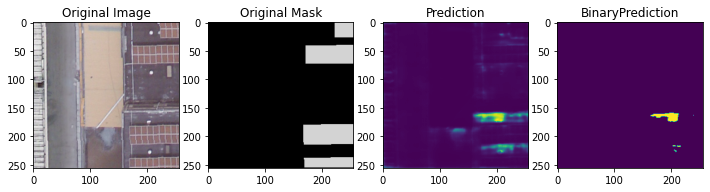

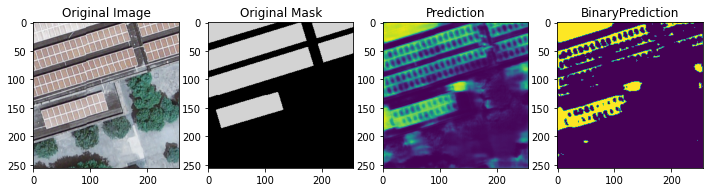

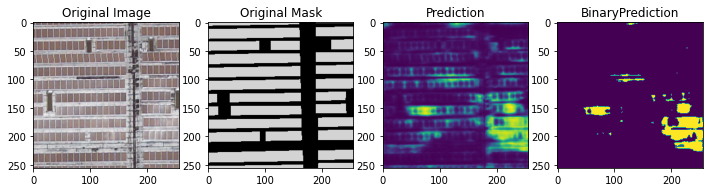

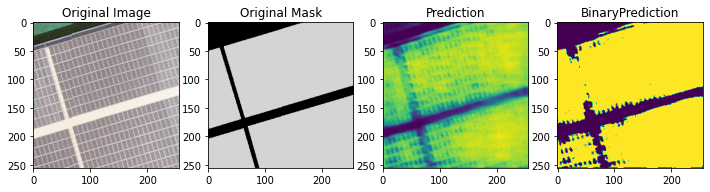

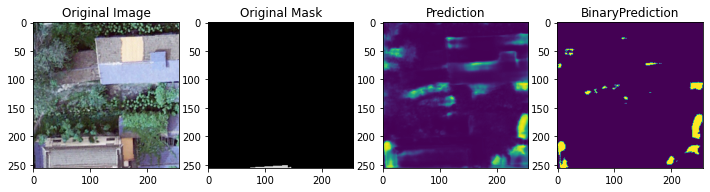

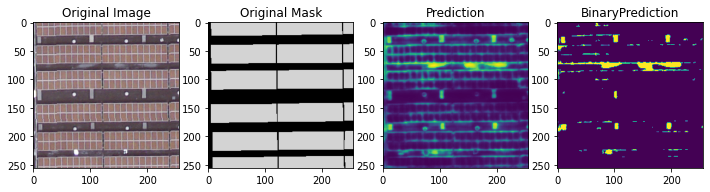

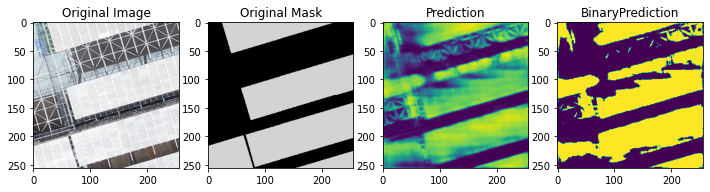

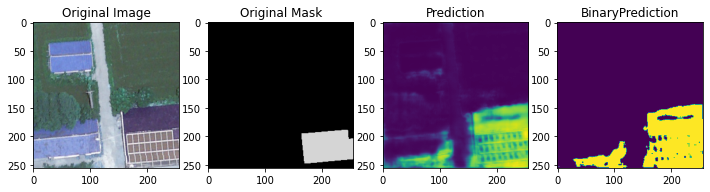

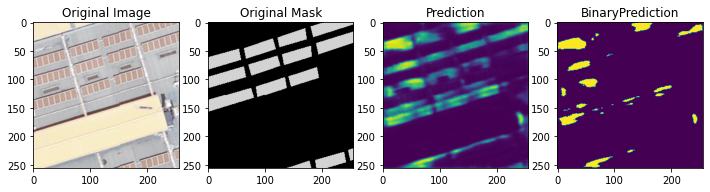

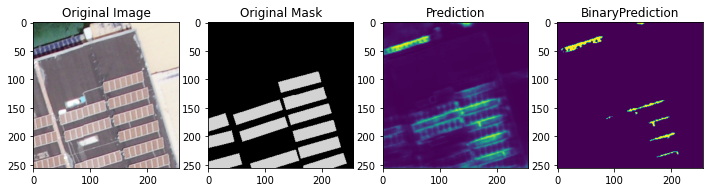

In [ ]:
for i in range(10):
    idx = random.randint(0,len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    img = cv2.resize(image,(ImgHeight,ImgWidth))
    img = img/255
    img = img[np.newaxis,:,:,:]
    pred=model.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('BinaryPrediction')
    plt.show()

# **Prediction Visualization**

In [ ]:
for i in range(10):
    idx = random.randint(0,len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    img = cv2.resize(image,(ImgHeight,ImgWidth))
    img = img/255
    img = img[np.newaxis,:,:,:]
    pred=model.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('BinaryPrediction')
    plt.show()

**FIN** 



